# Covid 19 Chest X-Ray Analysis with GradCam

In this Notebook I use a pretrained `densenet121` for analysing Covid-19 Xrays and Visualise them using GradCam algorithm.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import io, transform
from torch.utils.data import Dataset
import torch
import os
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from PIL import Image,ImageOps
import torchvision
from torch import optim,nn
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tqdm
import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
from util_grad import *

## Read  and  Process  Data

In [3]:
## Define transfoms
standard_normalization = transforms.Normalize((0.5), (0.5))
data_transforms = transforms.Compose([transforms.RandomResizedCrop(256),
                                      transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     standard_normalization])
data_transforms_1 = transforms.Compose([transforms.RandomResizedCrop(256),
                                     transforms.ToTensor(),
                                     standard_normalization])

In [4]:
# Read Data
dict_ = {0:"Covid",1:"Lung_Opacity",2:"Normal",3:"Viral Pheumonia"}

df = pd.read_csv("../input/processed-csv/data.csv")
df = pd.concat([df,pd.get_dummies(df.tag)], axis=1)


In [5]:
#make train, test and val set

train, test = train_test_split(df,test_size=.2)
train_, val = train_test_split(train,test_size=.2)

In [6]:
#reseting index
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)
train_ = train_.reset_index(drop=True)
val = val.reset_index(drop=True)

In [7]:
from torch.utils.data import  WeightedRandomSampler
class_freq = torch.tensor(train_.tag.values).bincount()
weight = 1 / class_freq
samples_weight = weight[train_.tag.values]
sampler = WeightedRandomSampler(samples_weight, len(samples_weight), replacement=True)

In [8]:
root_dir = "../input/covid19-radiography-database/COVID-19_Radiography_Dataset"

trainset = Xray_dataset(train,root_dir,transform = data_transforms)
train_loader = DataLoader(trainset, batch_size=32, shuffle=True)

testset = Xray_dataset(test,root_dir,transform = data_transforms_1)
test_loader = DataLoader(testset, batch_size=32, shuffle=True)

trainset_ = Xray_dataset(train_,root_dir,transform = data_transforms)
train_loader_ = DataLoader(trainset_, batch_size=32, sampler=sampler)

valset = Xray_dataset(val,root_dir,transform = data_transforms)
val_loader = DataLoader(valset, batch_size=32, shuffle=True)

use_cuda = torch.cuda.is_available()
num_classes = 4

loaders = {"train": train_loader_,
           "test": test_loader,
           "val": val_loader}

## Download and Prepare Neural Network

In [9]:
model = torchvision.models.resnet18(pretrained = True, progress = True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [10]:
model.fc = nn.Linear(in_features=512, out_features=num_classes, bias=True)
if use_cuda:
    model = model.cuda()

In [11]:
## Define Loss and optim
optimizer = optim.Adam(model.parameters(), lr=3e-5)
criterion = nn.CrossEntropyLoss()

## Train Model

In [12]:
## Train
train_model(20, loaders, model, optimizer, criterion, use_cuda, 'model_transfer.pt');

Epoch 1, Batch 1 loss: 1.513226
Epoch 1, Batch 51 loss: 0.946949
Epoch 1, Batch 101 loss: 0.779435
Epoch 1, Batch 151 loss: 0.692327
Epoch 1, Batch 201 loss: 0.639063
Epoch 1, Batch 251 loss: 0.599825
Epoch 1, Batch 301 loss: 0.563141
Epoch 1, Batch 351 loss: 0.536546
Epoch 1, Batch 401 loss: 0.514738
Epoch: 1 	Training Loss: 0.505730 	Validation Loss: 0.390163
Validation loss decreased (inf --> 0.390163).  Saving model ...
Epoch 2, Batch 1 loss: 0.271351
Epoch 2, Batch 51 loss: 0.343708
Epoch 2, Batch 101 loss: 0.340555
Epoch 2, Batch 151 loss: 0.333382
Epoch 2, Batch 201 loss: 0.336795
Epoch 2, Batch 251 loss: 0.334659
Epoch 2, Batch 301 loss: 0.331134
Epoch 2, Batch 351 loss: 0.321476
Epoch 2, Batch 401 loss: 0.319563
Epoch: 2 	Training Loss: 0.318641 	Validation Loss: 0.320924
Validation loss decreased (0.390163 --> 0.320924).  Saving model ...
Epoch 3, Batch 1 loss: 0.157032
Epoch 3, Batch 51 loss: 0.296491
Epoch 3, Batch 101 loss: 0.299756
Epoch 3, Batch 151 loss: 0.298377
Epoch 

## Load the Saved Weights

In [13]:
model = torch.load("./model_transfer.pt")

## Test Model

In [14]:
test_model(loaders,model,criterion,use_cuda)
conf_met(model,test_loader)

  0%|          | 0/133 [00:00<?, ?it/s]

Test Loss: 0.208171


Test Accuracy: 92% (3921/4233)


100%|██████████| 133/133 [00:30<00:00,  4.34it/s]


Confusion Metrix : 
[[ 665   27   36    2]
 [  14 1075  109    0]
 [  14   82 1928   11]
 [   0    0   15  255]]


## Draw GradCam Output

Grad-CAM: Gradient-weighted Class Activation Mapping

In [16]:
from sklearn.metrics import classification_report
def conf_met(model,test_loader):
    true = []
    pred = []
    test_loss = 0
    for img,tag in tqdm.tqdm(test_loader):
        img = img.cuda()
        op = model(img)
        #loss = criterion(output, target)
        #test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        pred+= list(op.data.max(1, keepdim=True)[1].cpu().squeeze().data.numpy())
        true += list(tag.data.numpy())

    print(f"\nConfusion Metrix : \n{classification_report(true,pred)}")
conf_met(model,test_loader)

100%|██████████| 133/133 [00:30<00:00,  4.30it/s]


Confusion Metrix : 
              precision    recall  f1-score   support

           0       0.97      0.92      0.94       730
           1       0.91      0.90      0.90      1198
           2       0.92      0.94      0.93      2035
           3       0.93      0.95      0.94       270

    accuracy                           0.92      4233
   macro avg       0.93      0.93      0.93      4233
weighted avg       0.93      0.92      0.92      4233



In [17]:
def grad(model,img,target_layer):
    feture = []
    def fet(m,i,o):
        feture.append(o)
    grad = []
    def grd(m,i,o):
        grad.append(o[0])
    h = target_layer.register_backward_hook(grd)
    g = target_layer.register_forward_hook(fet)
    y = model(img)
    y[:,y.argmax(dim=1).item()].backward()
    h.remove()
    g.remove()
    
    w = torch.mean(grad[-1],dim = [2,3])
    cam = w[:,:,None,None]*feture[-1]
    cam = torch.mean(cam,dim = 1).squeeze().detach().cpu()
    cam = np.maximum(cam,0)
    cam/= torch.max(cam)
    cam = cam.numpy()
    cam = cv2.resize(cam,(256,256))
    cam = np.uint8(255*cam)
  
    img = img.squeeze().cpu()

    plt.imshow(torch.mean(img, dim = 0),cmap = 'gray')
    plt.imshow(cam,alpha = min(0.4,)

In [84]:
dict_[int(testset[10][1].numpy())]


'Viral Pheumonia'

Covid


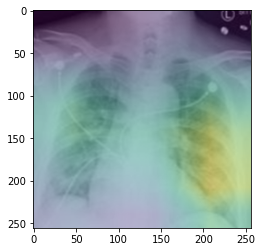

In [63]:
img  = testset[18][0].unsqueeze(0).cuda()
target = testset[18][1]
print(dict_[int(target.numpy())])
grad(model,img,model.layer4[-1])

Lung_Opacity


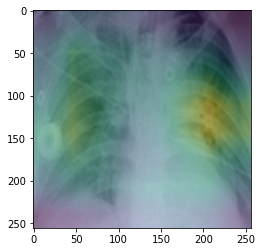

In [68]:
img  = testset[15][0].unsqueeze(0).cuda()
target = testset[15][1]
print(dict_[int(target.numpy())])
grad(model,img,model.layer4[-1])

Normal


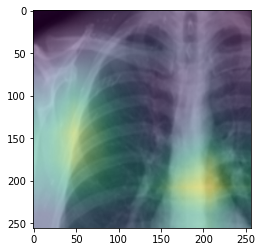

In [79]:
img  = testset[5][0].unsqueeze(0).cuda()
target = testset[5][1]
print(dict_[int(target.numpy())])
grad(model,img,model.layer4[-1])

Viral Pheumonia


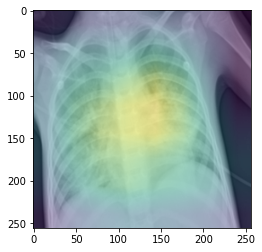

In [85]:
img  = testset[10][0].unsqueeze(0).cuda()
target = testset[10][1]
print(dict_[int(target.numpy())])
grad(model,img,model.layer4[-1])

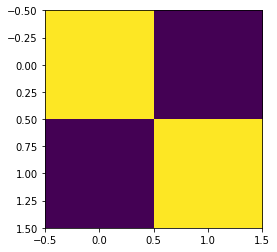

In [46]:
a = np.array([[1,0],[0,1]])
plt.imshow(a)